_Neural Data Science_

Lecturer: Dr. Jan Lause, Prof. Dr. Philipp Berens

Tutors: Jonas Beck, Fabio Seel, Julius Würzler

Summer term 2025

Student names: <span style='background: yellow'>*FILL IN YOUR NAMES HERE* </span>

LLM Disclaimer: <span style='background: yellow'>*Did you use an LLM to solve this exercise? If yes, which one and where did you use it? [Copilot, Claude, ChatGPT, etc.]* </span>

# Coding Lab 7 : Transcriptomics

In [2]:
import numpy as np
import pylab as plt
import pandas as pd
import matplotlib.pyplot as plt

# We recommend using openTSNE for experiments with t-SNE
# https://github.com/pavlin-policar/openTSNE
from openTSNE import TSNE

%matplotlib inline

%load_ext jupyter_black

%load_ext watermark
%watermark --time --date --timezone --updated --python --iversions --watermark -p sklearn

Last updated: 2025-06-04 17:33:23CEST

Python implementation: CPython
Python version       : 3.13.2
IPython version      : 9.0.2

sklearn: 1.6.1

pandas    : 2.2.3
openTSNE  : 1.0.2
numpy     : 2.2.3
matplotlib: 3.10.1

Watermark: 2.5.0



In [3]:
plt.style.use("../matplotlib_style.txt")

# Introduction

In this notebook you are going to work with transcriptomics data, in particular single-cell RNA sequencing (scRNA-seq) data from the paper by [Harris et al. (2018)](https://journals.plos.org/plosbiology/article?id=10.1371/journal.pbio.2006387). They recorded the transcriptomes of 3,663 inhibitory cells in the hippocampal area CA1. Their analysis divided these cells into 49 fine-scale clusters coresponding to different cell subtypes. They asigned names to these cluster in a hierarchical fashion according to strongly expressed gene in each clusters. The figure below shows the details of their classification. 

You will first analyze some of the most relevant statistics of UMI gene counts distributions, and afterwards follow the standard pipeline in the field to produce a visualization of the data.

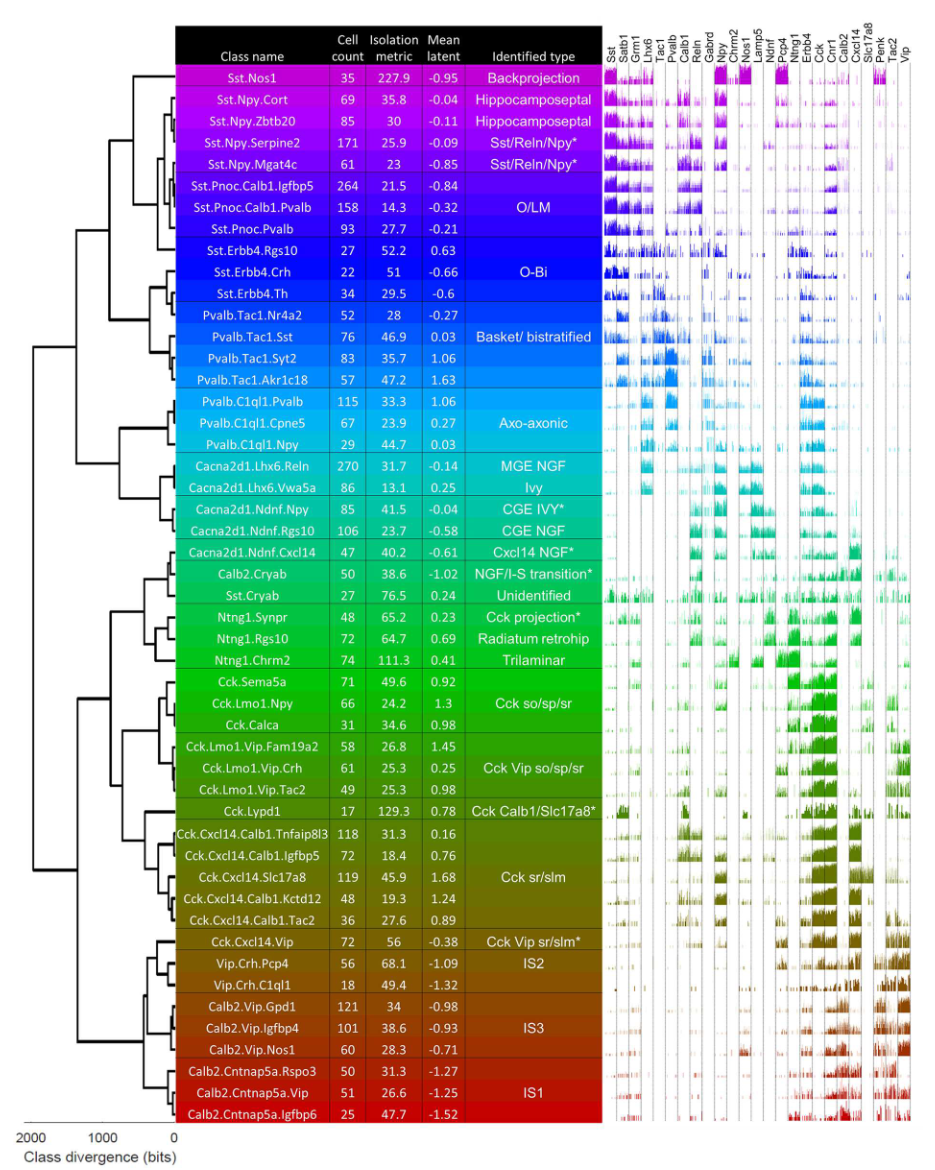

## Load data

Download the data from ILIAS, move it to the `data/` directory and unzip it there.
The read counts can be found in `counts`, with rows corresponding to cells and columns to genes.
The cluster assignments for every individual cell can be found in  `clusters`, along with the colors used in the publication in  `clusterColors`.

In [4]:
# LOAD HARRIS ET AL DATA

# Load gene counts
data = pd.read_csv("../data/nds_cl_7/harris-data/expression.tsv.gz", sep="\t")
genes = data.values[:, 0]
cells = data.columns[1:-1]
counts = data.values[:, 1:-1].transpose().astype("int")
data = []

# Kick out all genes with all counts = 0
genes = genes[counts.sum(axis=0) > 0]
counts = counts[:, counts.sum(axis=0) > 0]
print(counts.shape)

# Load clustering results
data = pd.read_csv("../data/nds_cl_7/harris-data/analysis_results.tsv", sep="\t")
clusterNames, clusters = np.unique(data.values[0, 1:-1], return_inverse=True)

# Load cluster colors
data = pd.read_csv("../data/nds_cl_7/harris-data/colormap.txt", sep="\s+", header=None)
clusterColors = data.values

# Note: the color order needs to be reversed to match the publication
clusterColors = clusterColors[::-1]

# Taken from Figure 1 - we need cluster order to get correct color order
clusterOrder = [
    "Sst.No",
    "Sst.Npy.C",
    "Sst.Npy.Z",
    "Sst.Npy.S",
    "Sst.Npy.M",
    "Sst.Pnoc.Calb1.I",
    "Sst.Pnoc.Calb1.P",
    "Sst.Pnoc.P",
    "Sst.Erbb4.R",
    "Sst.Erbb4.C",
    "Sst.Erbb4.T",
    "Pvalb.Tac1.N",
    "Pvalb.Tac1.Ss",
    "Pvalb.Tac1.Sy",
    "Pvalb.Tac1.A",
    "Pvalb.C1ql1.P",
    "Pvalb.C1ql1.C",
    "Pvalb.C1ql1.N",
    "Cacna2d1.Lhx6.R",
    "Cacna2d1.Lhx6.V",
    "Cacna2d1.Ndnf.N",
    "Cacna2d1.Ndnf.R",
    "Cacna2d1.Ndnf.C",
    "Calb2.Cry",
    "Sst.Cry",
    "Ntng1.S",
    "Ntng1.R",
    "Ntng1.C",
    "Cck.Sema",
    "Cck.Lmo1.N",
    "Cck.Calca",
    "Cck.Lmo1.Vip.F",
    "Cck.Lmo1.Vip.C",
    "Cck.Lmo1.Vip.T",
    "Cck.Ly",
    "Cck.Cxcl14.Calb1.Tn",
    "Cck.Cxcl14.Calb1.I",
    "Cck.Cxcl14.S",
    "Cck.Cxcl14.Calb1.K",
    "Cck.Cxcl14.Calb1.Ta",
    "Cck.Cxcl14.V",
    "Vip.Crh.P",
    "Vip.Crh.C1",
    "Calb2.Vip.G",
    "Calb2.Vip.I",
    "Calb2.Vip.Nos1",
    "Calb2.Cntnap5a.R",
    "Calb2.Cntnap5a.V",
    "Calb2.Cntnap5a.I",
]

reorder = np.zeros(clusterNames.size) * np.nan
for i, c in enumerate(clusterNames):
    for j, k in enumerate(clusterOrder):
        if c[: len(k)] == k:
            reorder[i] = j
            break
clusterColors = clusterColors[reorder.astype(int)]

<>:20: SyntaxWarning: invalid escape sequence '\s'
<>:20: SyntaxWarning: invalid escape sequence '\s'
<unknown>:20: SyntaxWarning: invalid escape sequence '\s'
/var/folders/ph/rzf8mr4124l1sb8_c8_qsrfr0000gn/T/ipykernel_36523/2453566246.py:20: SyntaxWarning: invalid escape sequence '\s'
  data = pd.read_csv("../data/nds_cl_7/harris-data/colormap.txt", sep="\s+", header=None)


(3663, 17965)


# Task 1: Data inspection
Before we use t-SNE or any other advanced visualization methods on the data, we first want to have a closer look on the data and plot some statistics. For most of the analysis we will compare the data to a Poisson distribution.


###  1.1. Relationship between expression mean and fraction of zeros
Compute actual and predicted gene expression. The higher the average expression of a gene, the smaller fraction of cells will show a 0 count. Plot the data and explain what you see in the plot.


_(3 pts)_

In [5]:
print(data)
print(genes)

         0       1       2
0   0.7692  0.0000  0.0000
1   0.7134  0.0726  0.0000
2   0.6652  0.1353  0.0000
3   0.6230  0.1901  0.0000
4   0.5859  0.2383  0.0000
5   0.5530  0.2812  0.0000
6   0.5235  0.3194  0.0000
7   0.4971  0.3538  0.0000
8   0.4731  0.3849  0.0000
9   0.4514  0.4132  0.0000
10  0.4306  0.4380  0.0000
11  0.4040  0.4584  0.0000
12  0.3749  0.4808  0.0000
13  0.3428  0.5056  0.0000
14  0.3071  0.5330  0.0000
15  0.2674  0.5635  0.0000
16  0.2229  0.5978  0.0000
17  0.1726  0.6365  0.0000
18  0.1153  0.6805  0.0000
19  0.0496  0.7311  0.0000
20  0.0000  0.7692  0.0261
21  0.0000  0.7692  0.1043
22  0.0000  0.7692  0.1825
23  0.0000  0.7692  0.2608
24  0.0000  0.7692  0.3390
25  0.0000  0.7692  0.4172
26  0.0000  0.7692  0.4954
27  0.0000  0.7692  0.5737
28  0.0000  0.7692  0.6519
29  0.0000  0.7692  0.7301
30  0.0000  0.7598  0.8005
31  0.0000  0.7386  0.8715
32  0.0000  0.7131  0.9562
33  0.0000  0.6441  1.0000
34  0.0000  0.5424  1.0000
35  0.0000  0.4407  1.0000
3

In [6]:
# ------------------------------------------------------
# Compute actual and predicted gene expression (1 pt)
# ------------------------------------------------------

# Compute the average expression for each gene
avg_expression = counts.mean(axis=0)
# Compute the fraction of zeros for each gene
zero_fraction = (counts == 0).mean(axis=0)

In [ ]:
# Compute the Poisson prediction
# (what is the expected fraction of zeros in a Poisson distribution with a given mean?)
poisson_prediction = np.exp(-avg_expression)
diff = zero_fraction - poisson_prediction

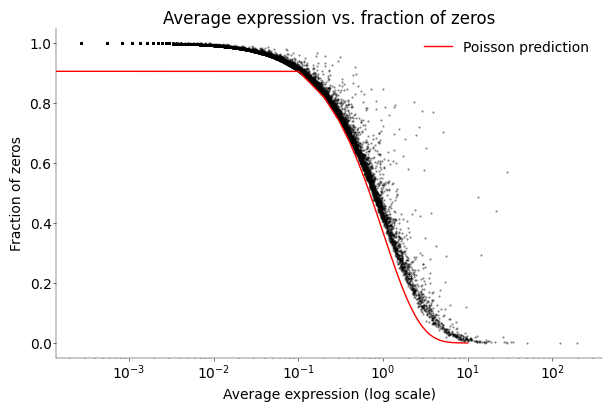

In [ ]:
# --------------------------------------------------
# plot the data and the Poisson prediction (1 pt)
# --------------------------------------------------

fig, ax = plt.subplots(figsize=(6, 4))
# add plot
ax.scatter(avg_expression, zero_fraction, s=1, color="black", alpha=0.5)

x = np.linspace(0, 10, 100)
ax.plot(x, np.exp(-x), color="red", label="Poisson prediction")

ax.set_xlabel("Average expression (log scale)")
ax.set_ylabel("Fraction of zeros")
ax.set_xscale("log")
ax.set_title("Average expression vs. fraction of zeros")
ax.legend()
plt.show()

_Explanation (1 pt)_
...

### 1.2. Mean-variance relationship

If the expression follows Poisson distribution, then the mean should be equal to the variance. Plot the mean-variance relationship and interpret the plot.

_(2.5 pts)_

In [9]:
# -------------------------------------------------------------------
# Compute the variance of the expression counts of each gene (0.5 pt)
# -------------------------------------------------------------------

variance = counts.var(axis=0)

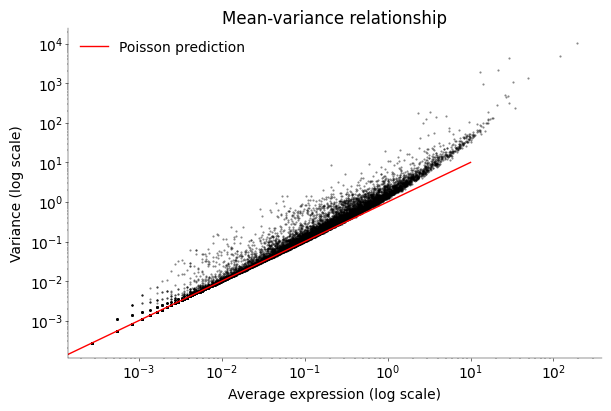

In [ ]:
# -------------------------------------------------------------
# Plot the mean-variance relationship on a log-log plot (1 pt)
# Plot the Poisson prediction as a line
# -------------------------------------------------------------

fig, ax = plt.subplots(figsize=(6, 4))
# add plot
ax.scatter(avg_expression, variance, s=1, color="black", alpha=0.5)

x = np.linspace(0, 10, 100)
ax.plot(x, x, color="red", label="Poisson prediction")

ax.set_xlabel("Average expression (log scale)")
ax.set_ylabel("Variance (log scale)")
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_title("Mean-variance relationship")
ax.legend()
plt.show()

_Explanation (1 pt)_
Genes with lower average expression tend to have a higher fraction of zeros, while genes with higher average expression exhibit fewer zeros.

The actual data deviates slightly from the Poisson prediction, particularly for genes with higher average expression. This shows that the gene expression data does not strictly follow a Poisson distribution, likely due to biological variability.

### 1.3. Relationship between the mean and the Fano factor

Compute the Fano factor for each gene and make a scatter plot of expression mean vs. Fano factor in log-log coordinates, and interpret what you see in the plot. If the expression follows the Poisson distribution, then the Fano factor (variance/mean) should be equal to 1 for all genes.

_(2.5 pts)_

In [11]:
# --------------------------------------------
# Compute the Fano factor for each gene (0.5 pt)
# --------------------------------------------

fano = variance / avg_expression

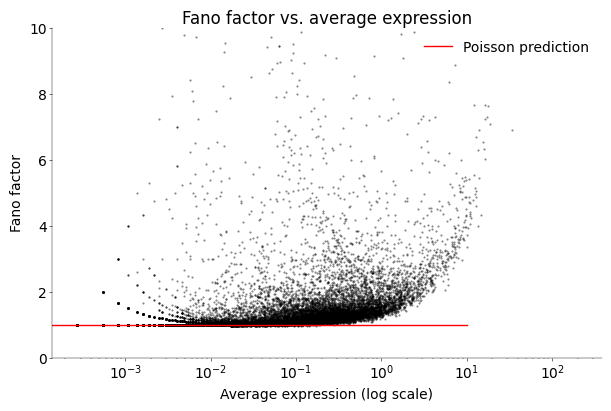

In [12]:
# -------------------------------
# plot fano-factor vs mean (1 pt)
# incl. fano factor
# -------------------------------
# Plot a Poisson prediction as line
# Use the same style of plot as above.

fig, ax = plt.subplots(figsize=(6, 4))
# add plot
ax.scatter(avg_expression, fano, s=1, color="black", alpha=0.5)
# add the Poisson prediction
x = np.linspace(0, 10, 100)
ax.plot(x, np.ones_like(x), color="red", label="Poisson prediction")
ax.set_xlabel("Average expression (log scale)")
ax.set_ylabel("Fano factor")
ax.set_xscale("log")
ax.set_ylim(0, 10)
ax.set_title("Fano factor vs. average expression")
ax.legend()
plt.show()

_Explanation (1 pt)_
...
For low-expression genes (left side): Many cluster near the red line — they may be driven by noise and low detection.
FOr high-expression genes (right side): Some genes show Fano factors much above 1, showing biological variability again.

### 1.4. Histogram of sequencing depths

Different cells have different sequencing depths (sum of counts across all genes) because the efficiency can change from droplet to droplet due to some random expreimental factors. Make a histogram of sequencing depths.

_(1.5 pts)_

In [13]:
# -------------------------------
# Compute sequencing depth (0.5 pt)
# -------------------------------

seq_depth = counts.sum(axis=1)

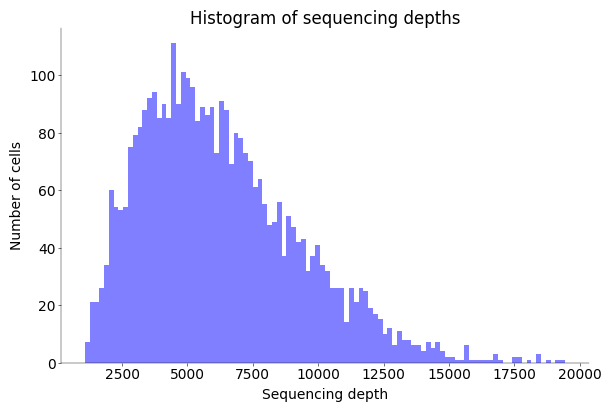

In [14]:
# ------------------------------------------
# Plot histogram of sequencing depths (1 pt)
# ------------------------------------------

fig, ax = plt.subplots(figsize=(6, 4))
ax.hist(seq_depth, bins=100, color="blue", alpha=0.5)
ax.set_xlabel("Sequencing depth")
ax.set_ylabel("Number of cells")
ax.set_title("Histogram of sequencing depths")
plt.show()

### 1.5. Fano factors after normalization

Normalize counts by the sequencing depth of each cell and multiply by the median sequencing depth. Then make the same expression vs Fano factor plot as above. After normalization by sequencing depth, Fano factor should be closer to 1 (i.e. variance even more closely following the mean). This can be used for feature selection.

_(2.5 pts)_

In [15]:
# -------------------------------------------------
# compute normalized counts and fano factor (1 pt)
# -------------------------------------------------
norm_counts = counts / seq_depth[:, np.newaxis]
median_depth = np.median(seq_depth)
norm_counts *= median_depth

norm_fano = norm_counts.var(axis=0) / norm_counts.mean(axis=0)

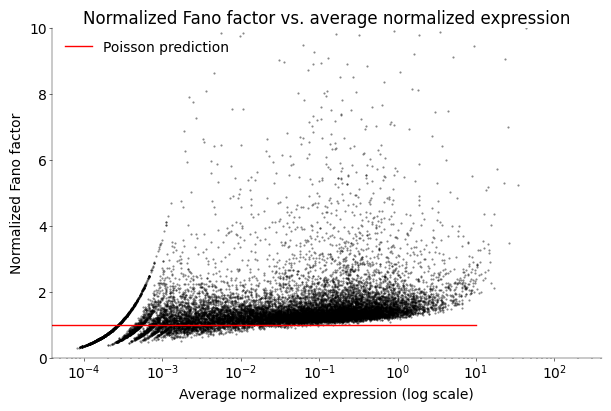

In [ ]:
# ----------------------------------------------------------
# plot normalized counts and find the top 10 genes (1 pt)
# hint: keep appropriate axis scaling in mind
# ----------------------------------------------------------

fig, ax = plt.subplots(figsize=(6, 4))
# add plot
ax.scatter(norm_counts.mean(axis=0), norm_fano, s=1, color="black", alpha=0.5)

x = np.linspace(0, 10, 100)
ax.plot(x, np.ones_like(x), color="red", label="Poisson prediction")

ax.set_xlabel("Average normalized expression (log scale)")
ax.set_ylabel("Normalized Fano factor")
ax.set_xscale("log")
ax.set_ylim(0, 10)
ax.set_title("Normalized Fano factor vs. average normalized expression")
ax.legend()
plt.show()

In [17]:
# --------------------------------------------------------------------
# Find top-10 genes with the highest normalized Fano factor (0.5 pts)
# Print them sorted by the Fano factor starting from the highest
# Gene names are stored in the `genes` array
# --------------------------------------------------------------------
top_genes_indices = np.argsort(norm_fano)[-10:][::-1]
top_genes = genes[top_genes_indices]
print("Top 10 genes with highest normalized Fano factor:")
print(top_genes)

Top 10 genes with highest normalized Fano factor:
['Sst' 'Npy' 'Vip' 'Cck' 'Cpne2' 'Pcp4' 'Ptpn23' 'Pdzd9' 'Malat1' 'Armc2']


# Task 2: Low dimensional visualization

In this task we will construct a two dimensional visualization of the data. First we will normalize the data with some variance stabilizing transformation and study the effect that different approaches have on the data. Second, we will reduce the dimensionality of the data to a more feasible number of dimensions (e.g. $d=50$) using PCA. And last, we will project the PCA-reduced data to two dimensions using t-SNE.

### 2.1. PCA with and without transformations

Here we look at the influence of variance-stabilizing transformations on PCA. We will focus on the following transformations: 
- Square root (`sqrt(X)`): it is a variance-stabilizing transformation for the Poisson data. 
- Log-transform (`log2(X+1)`): it is also often used in the transcriptomic community. 

We will only work with the most important genes. For that, transform the counts into normalized counts (as above) and select all genes with normalized Fano factor above 3 and remove the rest. We will look at the effect that both transformations have in the PCA-projected data by visualizing the first two components. Interpret qualitatively what you see in the plot and compare the different embeddings making use of the ground truth clusters.

_(3.5 pts)_

In [18]:
# --------------------------------
# Select important genes (0.5 pts)
# --------------------------------

important_genes_high_fano = genes[norm_fano > 3]
important_gene_indices = [
    np.where(genes == gene)[0][0] for gene in important_genes_high_fano
]
important_gene_counts = counts[:, important_gene_indices]

print("Genes with normalized Fano factor > 3:")
print(important_genes_high_fano)

Genes with normalized Fano factor > 3:
['Ogfrl1' 'Adgrb3' 'Arhgef4' 'Rev1' 'Creg2' 'AI597479' 'Coq10b'
 '1700066M21Rik' 'Raph1' 'Gm26649' 'Myl1' 'Fn1' 'Smarcal1' 'Igfbp5'
 'Rqcd1' 'Wnt10a' 'Resp18' 'Farsb' 'Serpine2' 'Dner' '2810459M11Rik'
 'Nppc' 'Thap4' 'Lypd1' 'Tmem163' 'Elk4' 'Syt2' 'Ppp1r12b' 'Trove2' 'Rgs8'
 'Qsox1' 'Rc3h1' 'Atp1b1' 'Rgs5' 'Rgs4' 'Fcer1g' 'Atp1a2' 'Desi2'
 'B230369F24Rik' 'Adck3' '6330403A02Rik' 'Eprs' 'Esrrg' 'Ppp2r5a'
 'Sec61a2' 'Ankrd16' 'Gm13269' 'Arl5b' 'Thnsl1' 'Gad2' 'Nxph2' 'Sapcd2'
 'Tmem141' 'Fam69b' 'Brd3' 'Olfm1' 'Gle1' 'Plpp7' 'Ttll11' 'Nek6' 'Nr6a1'
 'Scai' 'Lrp1b' 'Lypd6' 'Tbr1' 'Gad1' 'Pdk1' 'Sp3' 'Chn1' '2600014E21Rik'
 'Sestd1' 'Itga4' 'Zfp804a' 'Arhgap1' 'Cry2' 'Trp53i11' 'Tspan18' 'Slc1a2'
 'Lmo2' 'Scg5' 'Hypk' 'AA467197' 'Sppl2a' 'Avp' 'Ddrgk1' 'Ap5s1' 'Prnp'
 'Prokr2' 'Lamp5' 'Pcsk2os1' 'Cfap61' 'Cst3' 'Plagl2' 'Pigu' 'Uqcc1'
 'Cep250' 'Nnat' 'Snhg11' 'Sdc4' 'Snx21' 'Zfp64' 'Bcas1' 'Gm14342'
 'Ythdf1' 'Dgkk' 'Plp2' 'Pcsk1n' 'Akap17b' 'Sh2d1a

In [46]:
# --------------------------------------
# transform data and apply PCA (1 pt)
# --------------------------------------

# transfrom data
sqrt_data = np.sqrt(important_gene_counts)
log_data = np.log2(important_gene_counts + 1)

from sklearn.decomposition import PCA

# perform PCA
pca = PCA(n_components=50)
pca_raw = pca.fit_transform(important_gene_counts)
pca_sqrt = pca.fit_transform(sqrt_data)
pca_log = pca.fit_transform(log_data)

/var/folders/ph/rzf8mr4124l1sb8_c8_qsrfr0000gn/T/ipykernel_36523/3919861038.py:22: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


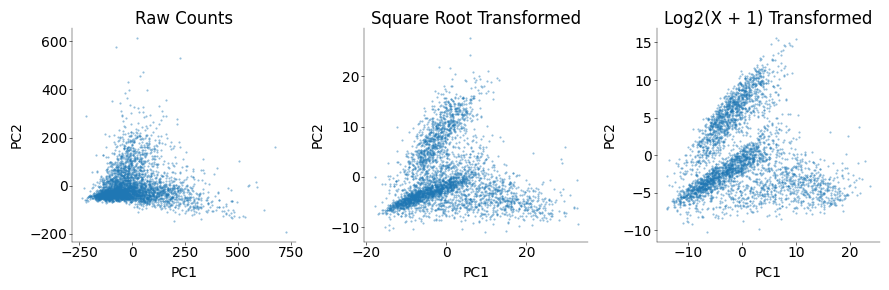

In [47]:
# ------------------------------------------------
# plot first 2 PCs for each transformation (1 pt)
# ------------------------------------------------

fig, axs = plt.subplots(1, 3, figsize=(9, 3))
# add plot
axs[0].scatter(pca_raw[:, 0], pca_raw[:, 1], s=1, alpha=0.5)
axs[0].set_title("Raw Counts")
axs[0].set_xlabel("PC1")
axs[0].set_ylabel("PC2")

axs[1].scatter(pca_sqrt[:, 0], pca_sqrt[:, 1], s=1, alpha=0.5)
axs[1].set_title("Square Root Transformed")
axs[1].set_xlabel("PC1")
axs[1].set_ylabel("PC2")

axs[2].scatter(pca_log[:, 0], pca_log[:, 1], s=1, alpha=0.5)
axs[2].set_title("Log2(X + 1) Transformed")
axs[2].set_xlabel("PC1")
axs[2].set_ylabel("PC2")

plt.tight_layout()
plt.show()

_Explanation (1 pt)_
...

- **Raw Counts**: The PCA projection of raw counts shows a wide spread of data points, indicating high variability. However, the distribution may be influenced by outliers or skewed data due to the lack of normalization or transformation.

- **Square Root Transformed**: The square root transformation stabilizes variance for Poisson-distributed data, resulting in a more compact and uniform spread in the PCA projection. This transformation reduces the influence of extreme values, making the data more suitable for dimensionality reduction.

- **Log2(X + 1) Transformed**: The log transformation further compresses the range of values, especially for high counts, and emphasizes differences in lower counts. The PCA projection of log-transformed data shows a distinct clustering pattern, suggesting that this transformation may better capture underlying structures in the data.


### 2.2. tSNE with and without transformations

Now, we will reduce the dimensionality of the PCA-reduced data further to two dimensions using t-SNE. We will use only $n=50$ components of the PCA-projected data. Plot the t-SNE embedding for the three versions of the data and interpret the plots. Do the different transformations have any effect on t-SNE?

_(1.5 pts)_

In [23]:
?TSNE

Init signature:
TSNE(
    n_components=2,
    *,
    perplexity=30.0,
    early_exaggeration=12.0,
    learning_rate='auto',
    max_iter=None,
    n_iter_without_progress=300,
    min_grad_norm=1e-07,
    metric='euclidean',
    metric_params=None,
    init='pca',
    verbose=0,
    random_state=None,
    method='barnes_hut',
    angle=0.5,
    n_jobs=None,
    n_iter='deprecated',
)
Docstring:     
T-distributed Stochastic Neighbor Embedding.

t-SNE [1] is a tool to visualize high-dimensional data. It converts
similarities between data points to joint probabilities and tries
to minimize the Kullback-Leibler divergence between the joint
probabilities of the low-dimensional embedding and the
high-dimensional data. t-SNE has a cost function that is not convex,
i.e. with different initializations we can get different results.

It is highly recommended to use another dimensionality reduction
method (e.g. PCA for dense data or TruncatedSVD for sparse data)
to reduce the number of dimension

In [22]:
# -----------------------
# Perform tSNE (0.5 pts)
# -----------------------

from sklearn.manifold import TSNE

pca_50_raw = PCA(n_components=50).fit_transform(important_gene_counts)
pca_50_sqrt = PCA(n_components=50).fit_transform(sqrt_data)
pca_50_log = PCA(n_components=50).fit_transform(log_data)

tsne_raw = TSNE(n_components=2, perplexity=30, random_state=42).fit_transform(
    pca_50_raw
)
tsne_sqrt = TSNE(n_components=2, perplexity=30, random_state=42).fit_transform(
    pca_50_sqrt
)
tsne_log = TSNE(n_components=2, perplexity=30, random_state=42).fit_transform(
    pca_50_log
)

TypeError: 'Axes' object is not subscriptable

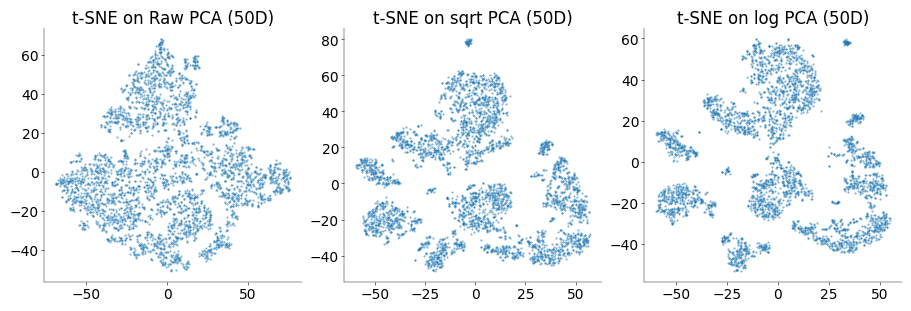

In [44]:
# -----------------------------------------------
# plot t-SNE embedding for each dataset (1 pt)
# -----------------------------------------------

fig, axs = plt.subplots(1, 3, figsize=(9, 3))
# add plot
axs[0].scatter(tsne_raw[:, 0], tsne_raw[:, 1], s=1, alpha=0.6)
axs[0].set_title("t-SNE on Raw PCA (50D)")

axs[1].scatter(tsne_sqrt[:, 0], tsne_sqrt[:, 1], s=1, alpha=0.6)
axs[1].set_title("t-SNE on sqrt PCA (50D)")

axs[2].scatter(tsne_log[:, 0], tsne_log[:, 1], s=1, alpha=0.6)
axs[2].set_title("t-SNE on log PCA (50D)")

ax[0].set_xlabel("t-SNE 1")
ax[0].set_ylabel("t-SNE 2")
ax[1].set_xlabel("t-SNE 1")
ax[1].set_ylabel("t-SNE 2")
ax[2].set_xlabel("t-SNE 1")
ax[2].set_ylabel("t-SNE 2")

plt.show()

### 2.3. Leiden clustering

Now we will play around with some clustering and see whether the clustering methods can produce similar results to the original clusters from the publication. We will apply Leiden clustering (closely related to the Louvain clustering), which is standard in the field and works well even for very large datasets. 

Choose one representation of the data (best transformation based in your results from the previous task) to use further in this task and justify your choice. Think about which level of dimensionality would be sensible to use to perform clustering. Visualize in the two-dimensional embedding the resulting clusters and compare to the original clusters. 

_(1.5 pts)_

In [27]:
# To run this code you need to install leidenalg and igraph
# conda install -c conda-forge python-igraph leidenalg

import igraph as ig
from sklearn.neighbors import NearestNeighbors, kneighbors_graph
import leidenalg as la

In [28]:
# Define some contrast colors

clusterCols = [
    "#FFFF00",
    "#1CE6FF",
    "#FF34FF",
    "#FF4A46",
    "#008941",
    "#006FA6",
    "#A30059",
    "#FFDBE5",
    "#7A4900",
    "#0000A6",
    "#63FFAC",
    "#B79762",
    "#004D43",
    "#8FB0FF",
    "#997D87",
    "#5A0007",
    "#809693",
    "#FEFFE6",
    "#1B4400",
    "#4FC601",
    "#3B5DFF",
    "#4A3B53",
    "#FF2F80",
    "#61615A",
    "#BA0900",
    "#6B7900",
    "#00C2A0",
    "#FFAA92",
    "#FF90C9",
    "#B903AA",
    "#D16100",
    "#DDEFFF",
    "#000035",
    "#7B4F4B",
    "#A1C299",
    "#300018",
    "#0AA6D8",
    "#013349",
    "#00846F",
    "#372101",
    "#FFB500",
    "#C2FFED",
    "#A079BF",
    "#CC0744",
    "#C0B9B2",
    "#C2FF99",
    "#001E09",
    "#00489C",
    "#6F0062",
    "#0CBD66",
    "#EEC3FF",
    "#456D75",
    "#B77B68",
    "#7A87A1",
    "#788D66",
    "#885578",
    "#FAD09F",
    "#FF8A9A",
    "#D157A0",
    "#BEC459",
    "#456648",
    "#0086ED",
    "#886F4C",
    "#34362D",
    "#B4A8BD",
    "#00A6AA",
    "#452C2C",
    "#636375",
    "#A3C8C9",
    "#FF913F",
    "#938A81",
    "#575329",
    "#00FECF",
    "#B05B6F",
    "#8CD0FF",
    "#3B9700",
    "#04F757",
    "#C8A1A1",
    "#1E6E00",
    "#7900D7",
    "#A77500",
    "#6367A9",
    "#A05837",
    "#6B002C",
    "#772600",
    "#D790FF",
    "#9B9700",
    "#549E79",
    "#FFF69F",
    "#201625",
    "#72418F",
    "#BC23FF",
    "#99ADC0",
    "#3A2465",
    "#922329",
    "#5B4534",
    "#FDE8DC",
    "#404E55",
    "#0089A3",
    "#CB7E98",
    "#A4E804",
    "#324E72",
    "#6A3A4C",
    "#83AB58",
    "#001C1E",
    "#D1F7CE",
    "#004B28",
    "#C8D0F6",
    "#A3A489",
    "#806C66",
    "#222800",
    "#BF5650",
    "#E83000",
    "#66796D",
    "#DA007C",
    "#FF1A59",
    "#8ADBB4",
    "#1E0200",
    "#5B4E51",
    "#C895C5",
    "#320033",
    "#FF6832",
    "#66E1D3",
    "#CFCDAC",
    "#D0AC94",
    "#7ED379",
    "#012C58",
]

clusterCols = np.array(clusterCols)

In [29]:
# ------------------------------------------------------
# create graph and run leiden clustering on it (0.5 pts)
# hint: use `la?`, `la.find_partition?` and `ig.Graph?`
# to find out more about the provided packages.
# ------------------------------------------------------

# Construct kNN graph with k=15
pca_50 = PCA(n_components=50).fit_transform(log_data)

A = A = kneighbors_graph(
    pca_50, n_neighbors=15, mode="connectivity", include_self=False
)

# Transform it into an igraph object

sources, targets = A.nonzero()
edges = list(zip(sources, targets))
G = ig.Graph(edges=edges, directed=False)

# Run Leiden clustering
# you can use `la.RBConfigurationVertexPartition` as the partition type
partition = la.find_partition(
    G, la.RBConfigurationVertexPartition, resolution_parameter=1.0
)
clusters = np.array(partition.membership)

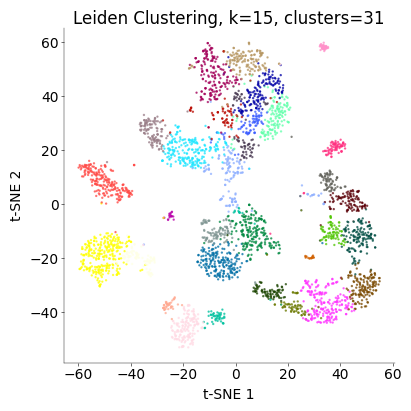

In [45]:
# --------------------------
# Plot the results (1 pt)
# --------------------------

fig, ax = plt.subplots(figsize=(4, 4))
n_clusters = len(np.unique(clusters))
ax.scatter(
    tsne_log[:, 0],
    tsne_log[:, 1],
    c=clusterCols[clusters % len(clusterCols)],
    s=2,
    alpha=0.7,
)
ax.set_title(f"Leiden Clustering, k={15}, clusters={n_clusters}")
ax.set_xlabel("t-SNE 1")
ax.set_ylabel("t-SNE 2")
plt.show()

### 2.4. Change the clustering resolution

The number of clusters can be changed by modifying the resolution parameter. How many clusters did we get with the default value? Change the resolution parameter to yield 2x more and 2x fewer clusters
Plot all three results as t-SNE overlays (same as above).

_(1.5 pts)_

In [42]:
# ------------------------------------------------------------------
# run the clustering for 3 different resolution parameters (0.5 pts)
# ------------------------------------------------------------------
resolutions = [0.2, 1.0, 2.9]

cluster_assignments = {}

for res in resolutions:
    partition = la.find_partition(
        G, la.RBConfigurationVertexPartition, resolution_parameter=res
    )
    clusters = np.array(partition.membership)
    cluster_assignments[res] = clusters

/var/folders/ph/rzf8mr4124l1sb8_c8_qsrfr0000gn/T/ipykernel_36523/3588167409.py:20: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


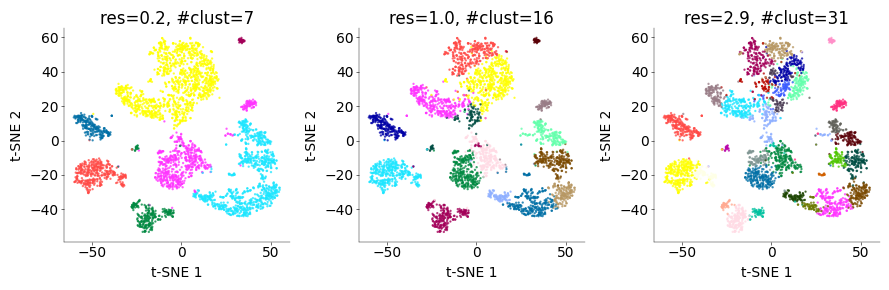

In [43]:
# --------------------------
# Plot the results (1 pt)
# --------------------------

fig, axs = plt.subplots(1, 3, figsize=(9, 3))
# add plot
for i, res in enumerate(resolutions):
    clusters = cluster_assignments[res]
    axs[i].scatter(
        tsne_log[:, 0],
        tsne_log[:, 1],
        c=clusterCols[clusters % len(clusterCols)],
        s=2,
        alpha=0.7,
    )
    axs[i].set_title(f"res={res}, #clust={len(np.unique(clusters))}")
    axs[i].set_xlabel("t-SNE 1")
    axs[i].set_ylabel("t-SNE 2")

plt.tight_layout()
plt.show()